In [ ]:
%pip install opencv-python

  Using cached opencv_python-4.7.0.72-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (61.8 MB)
Note: you may need to restart the kernel to use updated packages.


In [1]:
%cd /content/GP_try/test

/content/GP_try/test


In [1]:
import sys; sys.path.append("../")
from feature_extractor import FeatureExtractor
import torch
import numpy as np
import time
from cascade import CascadeClassifier
import cv2
import joblib


In [2]:
torch.cuda.is_available()

True

In [6]:
!mkdir ../new_data5/
!cp -r /content/drive/MyDrive/GP/GP_try/new_data5/* ../new_data5/

In [7]:
!ls ../new_data5/test/face -1 | wc -l
!ls ../new_data5/test/non-face -1 | wc -l
!ls ../new_data5/train/face -1 | wc -l
!ls ../new_data5/train/non-face -1 | wc -l

905
1810
3618
7236


In [8]:
!mkdir ../no_faces/
!cp -r /content/drive/MyDrive/SBI/SelfBlendedImages/no_faces/* ../no_faces/

In [9]:
!ls /content/drive/MyDrive/SBI/SelfBlendedImages/no_faces -1 | wc -l

1000


In [12]:
!mkdir ../hFeatures5_5

In [3]:
parent = '../hFeatures5_6/'
data_path = 'new_data5'

# Features Extraction

In [5]:
mean = 111.02404842061983
std = 56.926623499738575

In [4]:
def transform1(img):
  return img
  # img = (img - img.mean()) / (img.std() + 1e-8)
  # return cv2.normalize(img, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)

In [40]:
shape=(15, 15)

In [41]:

feature_extractor = FeatureExtractor(shape=shape,
                                     percentile=100,
                                     batch_size=500,
                                     verbose=False,
                                     all_features_file=parent + "all_features.npz",
                                     selected_features_file=parent + "selected_features.npz",
                                     labels_file=parent + "labels.npy",
                                     indecies_file=parent + "indecies.npy",)

In [42]:
class Data:pass
data = Data() # to be able to add attributes to it (data.X, data.y). This is to avoid copying the data in memory

In [43]:

# X, y = feature_extractor.extractFeatures(pos_path='../'+data_path+'/train/face',
data.X, data.y = feature_extractor.extractFeatures(pos_path='../'+data_path+'/train/face',
                                  neg_path='../'+data_path+'/train/non-face',
                                  transform=transform1,
                                  save_to_file=False)
print('done')


done


In [ ]:
import gc
gc.collect()

49

In [ ]:
# del feature_extractor.f2
# del feature_extractor.f3
# del feature_extractor.f4

In [ ]:
# indecies, X = feature_extractor.selectPercentile(X, y )
# # y = np.load(parent + 'labels.npy')
# print(X.shape, y.shape)
# print('done')


Now selecting percentile features
(12792, 10854) (10854,)
done


In [ ]:
# feature_extractor.f2, feature_extractor.f3, feature_extractor.f4 = feature_extractor.describe_features(feature_extractor.shape)

In [44]:
# temp = np.load('../hFeatures3/all_features.npz')['arr_0']
temp = data.X
temp

array([[ -6.,  -5.,  -6., ...,  -1.,   7.,   2.],
       [ 13.,   5., -37., ...,   0.,  -8.,   2.],
       [-42.,  -4., -40., ...,  -5.,  -2., -13.],
       ...,
       [ -3.,  22.,  20., ...,   1.,   5.,   7.],
       [ -2.,   0.,  -3., ...,   0.,   1.,   6.],
       [  5.,   0.,  -5., ...,   0.,   1.,  -9.]], dtype=float32)

In [45]:
print(temp.min())
print(temp.max())
print(temp[3])
print(temp[4])

-24233.0
20896.0
[ 23.   7. -84. ...   0. -11.   8.]
[ -27.   27. -121. ...  -12.   10.    7.]


# Training

In [ ]:
!mkdir /content/drive/MyDrive/GP/GP_try/hFeatures5_4/

mkdir: cannot create directory ‘/content/drive/MyDrive/GP/GP_try/hFeatures5_4/’: File exists


In [46]:
face_detect_dict = {
    "feature_extractor":feature_extractor,
    "window_size":shape,
    "scale_dist":1.25,
    "max_size":500,
    "min_size":50,
    "stride":10,
    "device":torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    "normalize_subwindows":False,
    "calc_conf":False
}

In [47]:
more_neg_dict = {
    "more_neg_path":'../../FF++/no_faces/',
    "n_per_img":20,
    "req_cnt":6000,
    "by_confidence":True,
    "by_size":True,
    "resize_factor":0.25,
    "face_dict":face_detect_dict
}

In [48]:
s_t = time.time()
cascadeClassifier= CascadeClassifier(batchsize=500,
                                     verbose=True,
                                     layers=[50]*3)

face_detect_dict['classifier'] = cascadeClassifier
s = '/content/drive/MyDrive/GP/GP_try/hFeatures5_6/'
tr_acc = cascadeClassifier.train(data=data, equal_weights=False,print_accuracy=True,more_neg_dict=more_neg_dict)

cascadeClassifier.save(parent + 'cascadeClassifier.pkl')

print('accuracy: ', tr_acc)
print('time taken: ', time.time() - s_t, 's')
print('done')

Training strong classifier 001: 100%|██████████| 50/50 [02:00<00:00,  2.41s/it]


For layer 1 accuracy is 0.9792703150912107


Images:  24%|██▍       | 243/1000 [01:35<04:57,  2.54it/s]


Added 5976 negative samples, Total negatives:  6117


Training strong classifier 002: 100%|██████████| 50/50 [01:42<00:00,  2.04s/it]


For layer 2 accuracy is 0.9222393425783256


Images:  32%|███▏      | 324/1000 [04:00<08:21,  1.35it/s] 


Added 5482 negative samples, Total negatives:  5952


Training strong classifier 003: 100%|██████████| 50/50 [01:48<00:00,  2.17s/it]


For layer 3 accuracy is 0.8826541274817137
accuracy:  None
time taken:  676.8648111820221 s
done


In [49]:
print(data.X.shape)
print(data.y.shape)
print(np.sum(data.y==1))
print(np.sum(data.y!=1))

(24976, 9570)
(9570,)
3618
5952


In [50]:
cascadeClassifier.save_joblib(parent + 'cascadeClassifier.joblib')

In [51]:
joblib.dump(feature_extractor, parent + 'feature_extractor.joblib')

['../hFeatures5_6/feature_extractor.joblib']

In [14]:
!cp -r ../hFeatures5_5/ /content/drive/MyDrive/GP/GP_try/hFeatures5_5/

In [ ]:
# import pickle as pkl
# with open(parent + 'cascadeClassifier.pkl', 'rb') as f:
#   cascadeClassifier = pkl.load(f)

# Testing

In [20]:
# accuracy imports
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix


In [52]:
s_t = time.time()
t_f_idx_map, t_features, t_labels = feature_extractor.extractFeaturesByIndecies(pos_path='../'+data_path+'/test/face',
                                            neg_path='../'+data_path+'/test/non-face',
                                            cascadeClassifier=cascadeClassifier,
                                            transform=transform1,
                                            use_percentile=False,)
print(t_features.shape, t_labels.shape)
predictions = cascadeClassifier.predict(t_features, t_f_idx_map)
print('test accuracy: ', np.sum(predictions == t_labels) / t_labels.shape[0])
print('time taken: ', time.time() - s_t, 's')

(141, 2715) (2715,)
test accuracy:  0.9484346224677717
time taken:  8.175473928451538 s


In [53]:
# report
print('accuracy: ', accuracy_score(t_labels, predictions))
print('f1 score macro: ', f1_score(t_labels, predictions, average='macro'))
print('f1 score binary: ', f1_score(t_labels, predictions))
print('f1 score micro: ', f1_score(t_labels, predictions, average='micro'))
print('precision: ', precision_score(t_labels, predictions))
print('recall: ', recall_score(t_labels, predictions))
print('confusion matrix: \n', confusion_matrix(t_labels, predictions))
print('classification report: \n', classification_report(t_labels, predictions, digits=4))


accuracy:  0.9484346224677717
f1 score macro:  0.9395871134433533
f1 score binary:  0.9164677804295943
f1 score micro:  0.9484346224677717
precision:  0.9961089494163424
recall:  0.8486187845303867
confusion matrix: 
 [[1807    3]
 [ 137  768]]
classification report: 
               precision    recall  f1-score   support

           0     0.9295    0.9983    0.9627      1810
           1     0.9961    0.8486    0.9165       905

    accuracy                         0.9484      2715
   macro avg     0.9628    0.9235    0.9396      2715
weighted avg     0.9517    0.9484    0.9473      2715



# Try full image

In [ ]:
# !mkdir /content/drive/MyDrive/GP/GP_try/hFeatures8
# !cp -r ../hFeatures8/* /content/drive/MyDrive/GP/GP_try/hFeatures8

mkdir: cannot create directory ‘/content/drive/MyDrive/GP/GP_try/hFeatures5_3’: File exists


In [18]:
!mkdir ../../lfw_all
!cp /content/drive/MyDrive/GP/lfw_all/* ../../lfw_all/

In [ ]:
!mkdir ../../ff_all
!cp /content/drive/MyDrive/SBI/SelfBlendedImages/full_frames/* ../../ff_all/

In [54]:
import random
# from detect_face import FaceDetector
from PIL import Image
import os
import matplotlib.pyplot as plt
dset_path='../../FF++/full_frames/'
# dset_path = '../../ff_all/'
# dset_path = '../../lfw_all/'
all_images_names = os.listdir(dset_path)
# all_images_names = sorted(all_images_names)
random.shuffle(all_images_names)
all_images_names = [dset_path + name for name in all_images_names]
all_images_names[0]

'../../FF++/full_frames/223..png'

In [55]:
show_images = list(range(0, 20))
rectangles_only = True
# resize_to = (100, 100)
random.shuffle(all_images_names)

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
feature_extractor.verbose = False

In [28]:
from copy import deepcopy

In [27]:
import joblib

In [66]:
cascadeClassifier2 = joblib.load('../hFeatures5_6/cascadeClassifier.joblib')
feature_extractor2 = joblib.load('../hFeatures5_6/feature_extractor.joblib')

In [ ]:
from importlib import reload
import detect_face
reload(detect_face)
from detect_face import MinFaceDetector

In [67]:
from detect_face import MinFaceDetector
faceDetector = MinFaceDetector(cascadeClassifier2, \
                            feature_extractor2,\

                            window_size=shape,
                            scale_dist=1.25,
                            max_size=500,
                            min_size=50,
                            stride=10,

                            device=device,
                            use_percentile=False,
                            # makeθ0=False,

                            # verbose=False,
                            normalize_subwindows=False,
                            calc_conf=True,
                            # report_time=True,
                            # use_sklearn=False
                            )

In [68]:
# joblib.dump(faceDetector, '/content/drive/MyDrive/GP/GP_try/hFeatures5_6/faceDetector.joblib')
joblib.dump(faceDetector, '../hFeatures5_6/faceDetector.joblib')

['../hFeatures5_6/faceDetector.joblib']

In [60]:
import cv2
import numpy as np

RGB
(480, 656, 3)
(240, 328)
{'Getting Subwindows': 0.013242006301879883, 'Resizing Subwindows': 0.00574183464050293, 'Normalize': 8.106231689453125e-06, 'Extracting Features': 0.03315377235412598, 'Classifying': 0.0231173038482666, 'total': 0.07526302337646484}


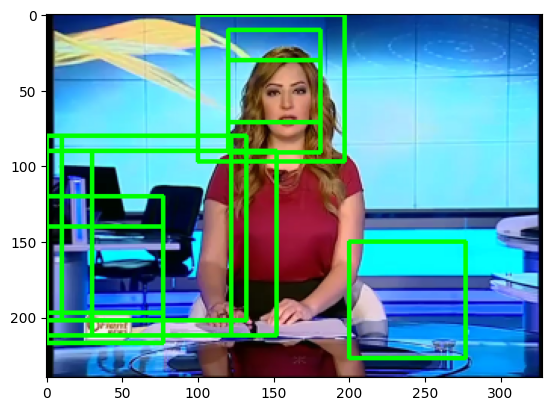

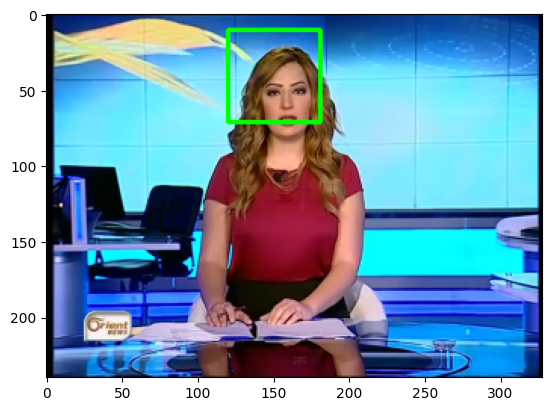

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.010867834091186523, 'Resizing Subwindows': 0.004410505294799805, 'Normalize': 5.7220458984375e-06, 'Extracting Features': 0.02425670623779297, 'Classifying': 0.019942522048950195, 'total': 0.05948328971862793}


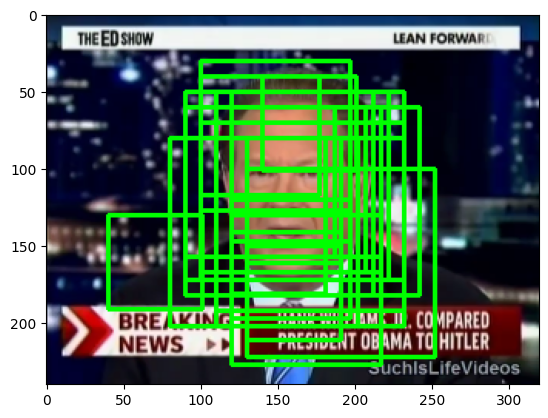

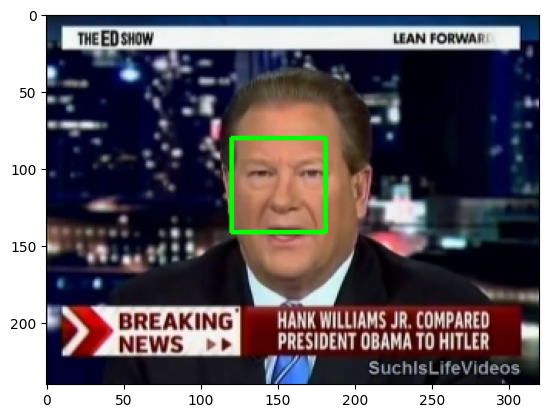

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.08492112159729004, 'Resizing Subwindows': 0.0061435699462890625, 'Normalize': 5.4836273193359375e-06, 'Extracting Features': 0.0410921573638916, 'Classifying': 0.025790691375732422, 'total': 0.15795302391052246}


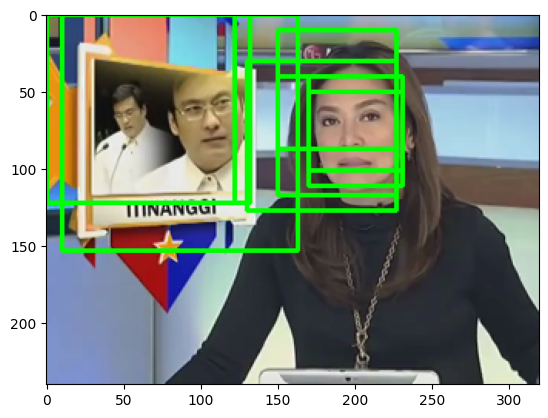

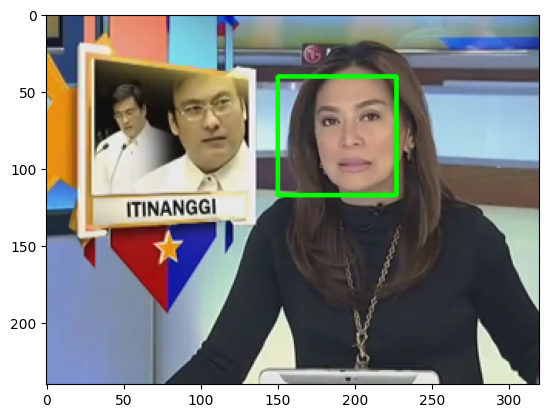

RGB
(1080, 1920, 3)
(540, 960)
{'Getting Subwindows': 0.4499325752258301, 'Resizing Subwindows': 0.20419073104858398, 'Normalize': 1.6689300537109375e-05, 'Extracting Features': 0.14961624145507812, 'Classifying': 0.09056830406188965, 'total': 0.894324541091919}


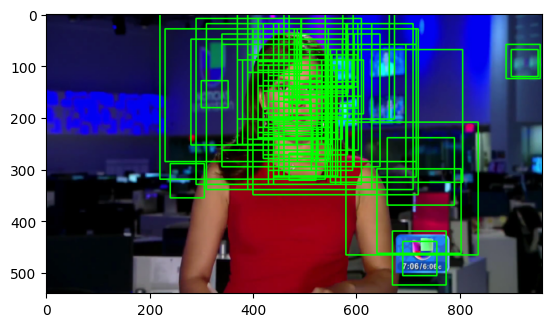

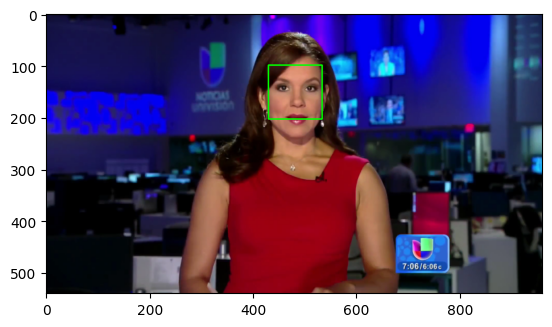

RGB
(1080, 1920, 3)
(540, 960)
{'Getting Subwindows': 0.4316527843475342, 'Resizing Subwindows': 0.18210339546203613, 'Normalize': 1.6689300537109375e-05, 'Extracting Features': 0.14600539207458496, 'Classifying': 0.06941509246826172, 'total': 0.8291933536529541}


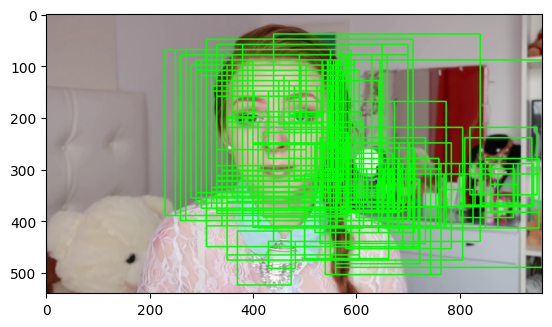

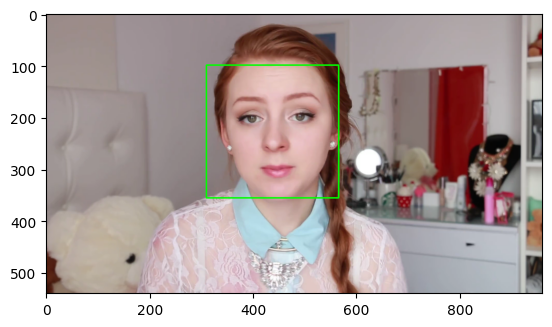

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.07689213752746582, 'Resizing Subwindows': 0.018975019454956055, 'Normalize': 5.9604644775390625e-06, 'Extracting Features': 0.04228043556213379, 'Classifying': 0.028591156005859375, 'total': 0.16674470901489258}


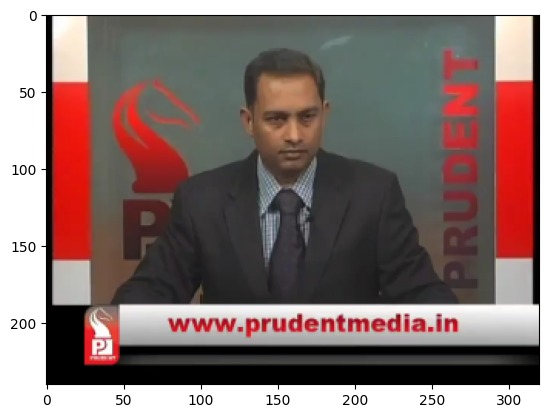

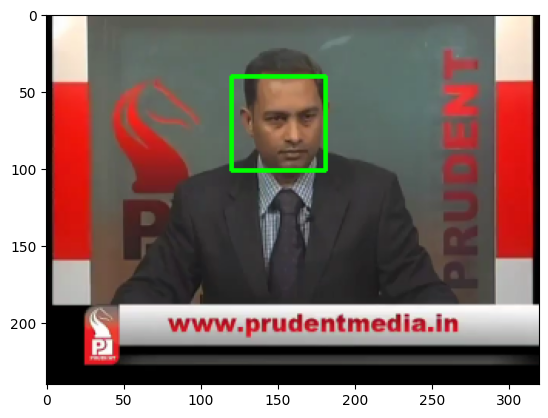

RGB
(720, 1280, 3)
(360, 640)
{'Getting Subwindows': 0.0778954029083252, 'Resizing Subwindows': 0.042090415954589844, 'Normalize': 9.5367431640625e-06, 'Extracting Features': 0.06113910675048828, 'Classifying': 0.03861546516418457, 'total': 0.21974992752075195}


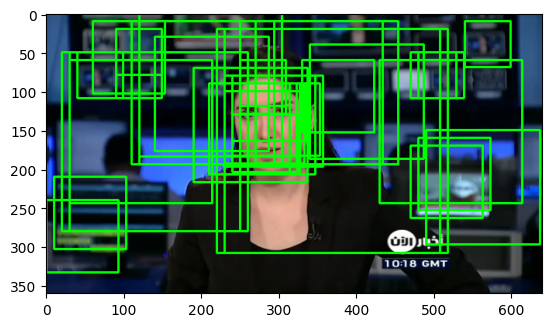

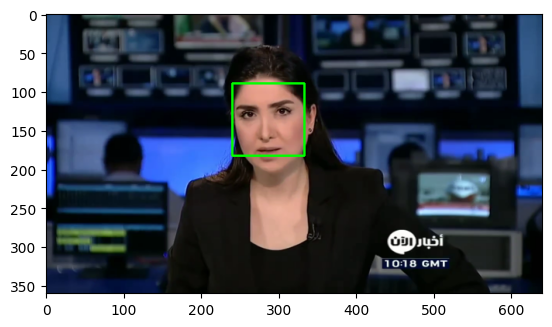

RGB
(1080, 1920, 3)
(540, 960)
{'Getting Subwindows': 0.3880195617675781, 'Resizing Subwindows': 0.18821310997009277, 'Normalize': 1.5974044799804688e-05, 'Extracting Features': 0.14186549186706543, 'Classifying': 0.06723713874816895, 'total': 0.7853512763977051}


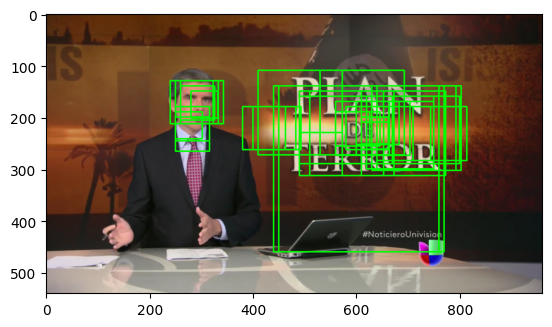

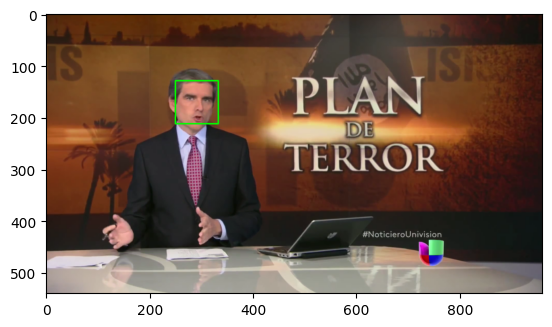

RGB
(480, 600, 3)
(240, 300)
{'Getting Subwindows': 0.010602712631225586, 'Resizing Subwindows': 0.004201650619506836, 'Normalize': 4.291534423828125e-06, 'Extracting Features': 0.025117874145507812, 'Classifying': 0.020962953567504883, 'total': 0.060889482498168945}


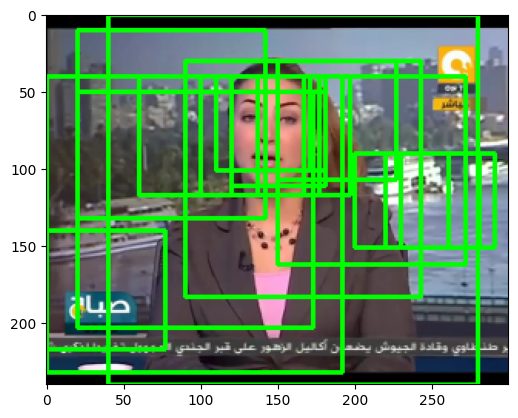

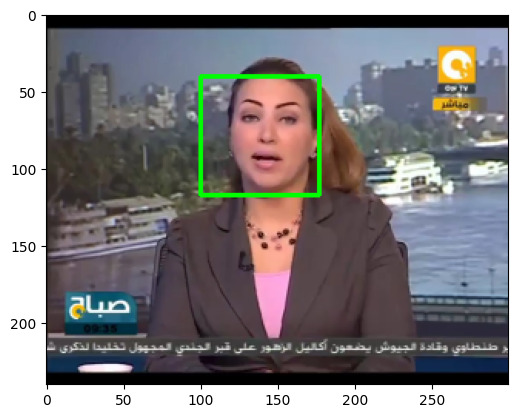

RGB
(480, 656, 3)
(240, 328)
{'Getting Subwindows': 0.0280914306640625, 'Resizing Subwindows': 0.031162261962890625, 'Normalize': 7.152557373046875e-06, 'Extracting Features': 0.06102895736694336, 'Classifying': 0.0280153751373291, 'total': 0.14830517768859863}


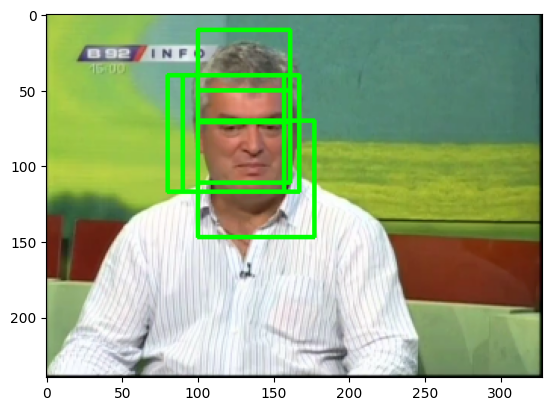

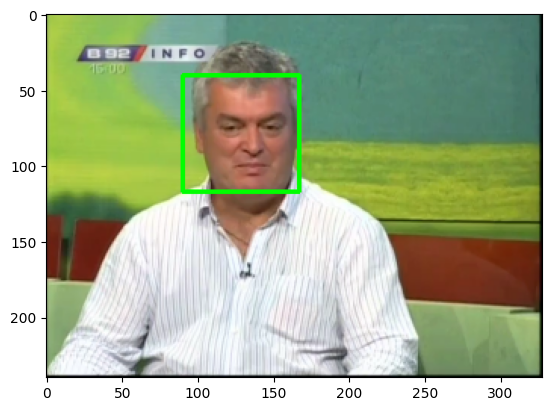

RGB
(1080, 1920, 3)
(540, 960)
{'Getting Subwindows': 0.4404582977294922, 'Resizing Subwindows': 0.2272484302520752, 'Normalize': 1.621246337890625e-05, 'Extracting Features': 0.18016552925109863, 'Classifying': 0.08288168907165527, 'total': 0.9307701587677002}


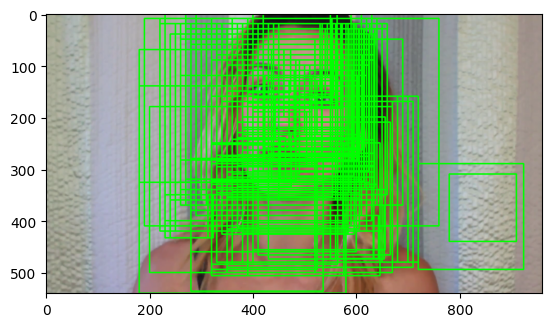

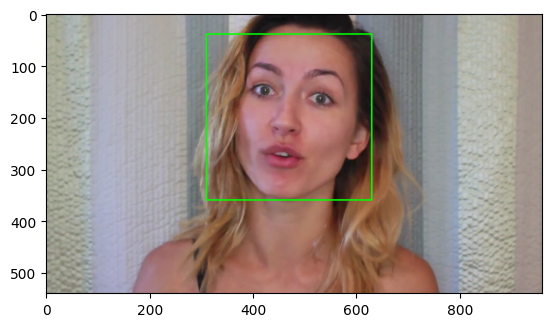

RGB
(480, 720, 3)
(240, 360)
{'Getting Subwindows': 0.015438318252563477, 'Resizing Subwindows': 0.005894899368286133, 'Normalize': 7.867813110351562e-06, 'Extracting Features': 0.04175901412963867, 'Classifying': 0.023154020309448242, 'total': 0.08625411987304688}


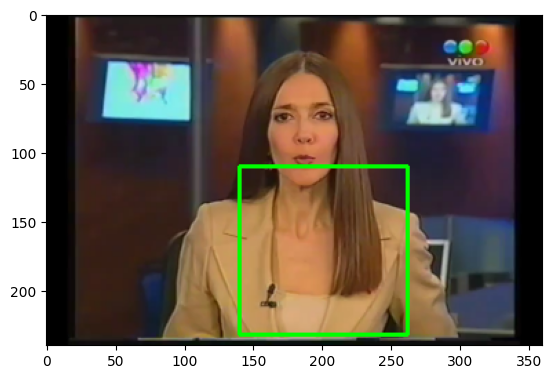

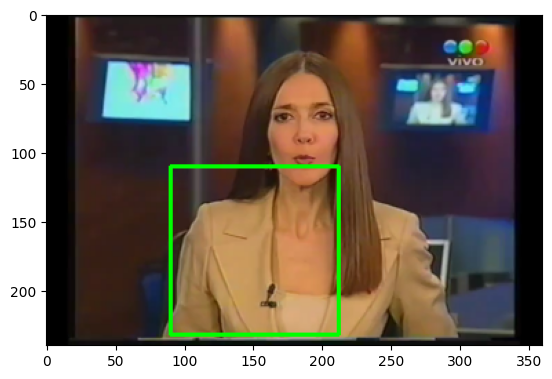

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.03696489334106445, 'Resizing Subwindows': 0.005464076995849609, 'Normalize': 7.152557373046875e-06, 'Extracting Features': 0.02451801300048828, 'Classifying': 0.025510072708129883, 'total': 0.09246420860290527}


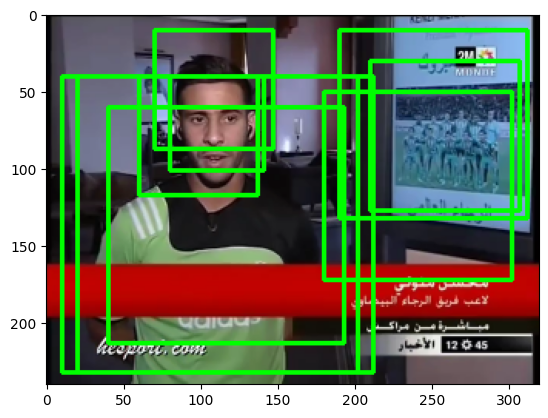

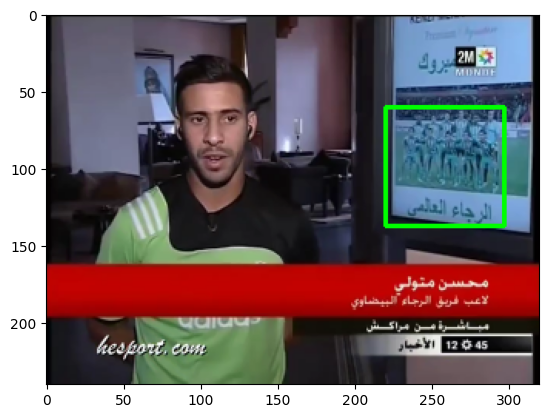

RGB
(480, 656, 3)
(240, 328)
{'Getting Subwindows': 0.012748241424560547, 'Resizing Subwindows': 0.005181550979614258, 'Normalize': 5.0067901611328125e-06, 'Extracting Features': 0.02985405921936035, 'Classifying': 0.02476024627685547, 'total': 0.07254910469055176}


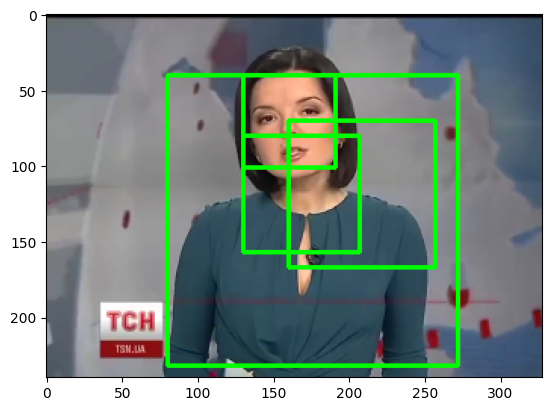

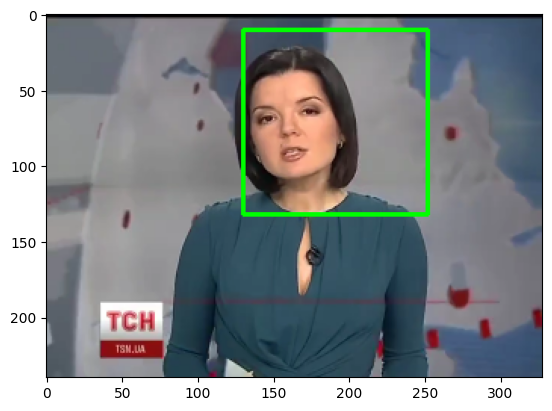

RGB
(720, 1280, 3)
(360, 640)
{'Getting Subwindows': 0.10790300369262695, 'Resizing Subwindows': 0.0898747444152832, 'Normalize': 1.2159347534179688e-05, 'Extracting Features': 0.06723523139953613, 'Classifying': 0.04338979721069336, 'total': 0.30841493606567383}


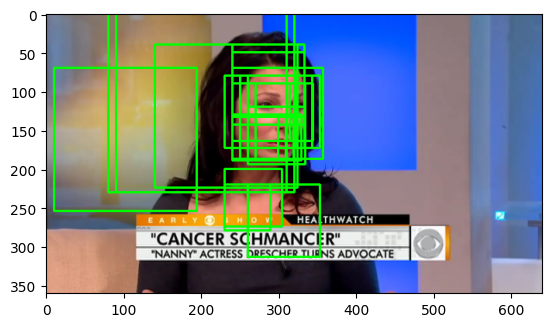

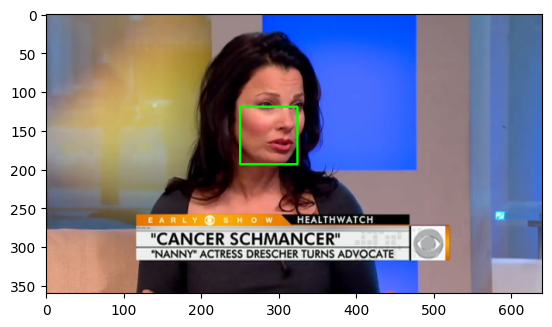

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.019662857055664062, 'Resizing Subwindows': 0.0051081180572509766, 'Normalize': 5.9604644775390625e-06, 'Extracting Features': 0.032221078872680664, 'Classifying': 0.026777029037475586, 'total': 0.08377504348754883}


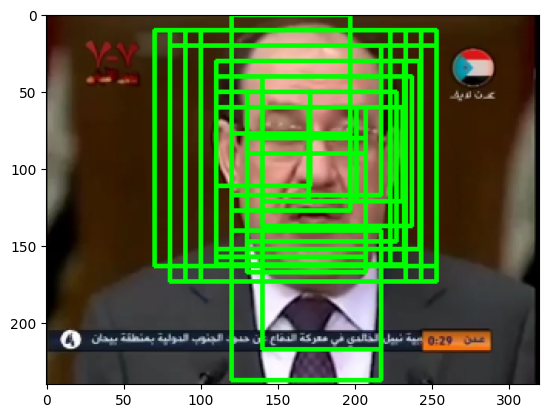

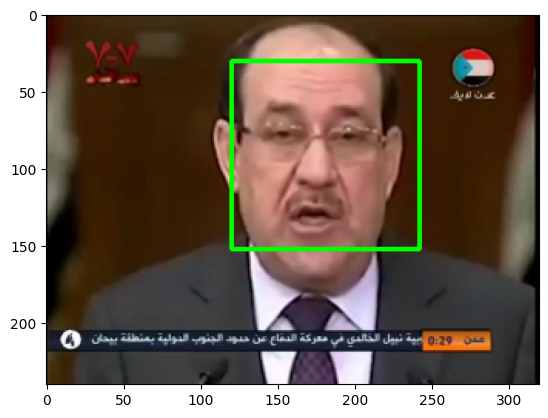

RGB
(480, 640, 3)
(240, 320)
{'Getting Subwindows': 0.012379884719848633, 'Resizing Subwindows': 0.005068778991699219, 'Normalize': 5.9604644775390625e-06, 'Extracting Features': 0.02754521369934082, 'Classifying': 0.024197101593017578, 'total': 0.06919693946838379}


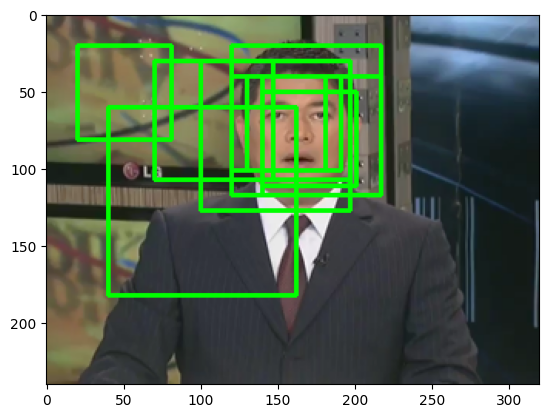

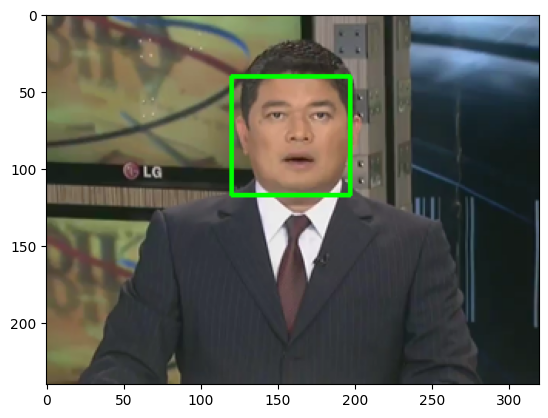

RGB
(480, 656, 3)
(240, 328)
{'Getting Subwindows': 0.04526686668395996, 'Resizing Subwindows': 0.00507664680480957, 'Normalize': 6.198883056640625e-06, 'Extracting Features': 0.04376506805419922, 'Classifying': 0.024066925048828125, 'total': 0.11818170547485352}


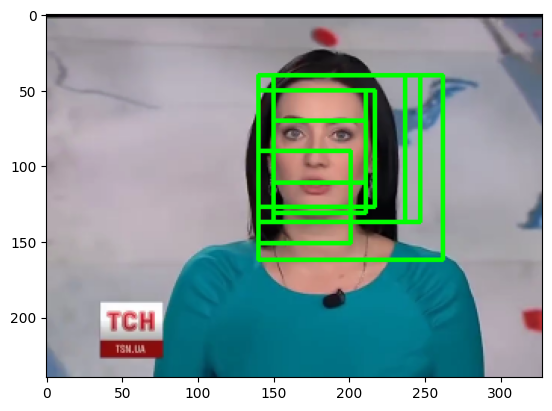

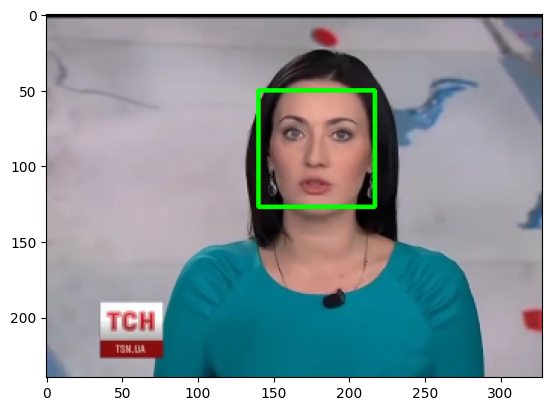

RGB
(480, 656, 3)
(240, 328)
{'Getting Subwindows': 0.026486635208129883, 'Resizing Subwindows': 0.0058367252349853516, 'Normalize': 7.3909759521484375e-06, 'Extracting Features': 0.029118061065673828, 'Classifying': 0.025304555892944336, 'total': 0.08675336837768555}


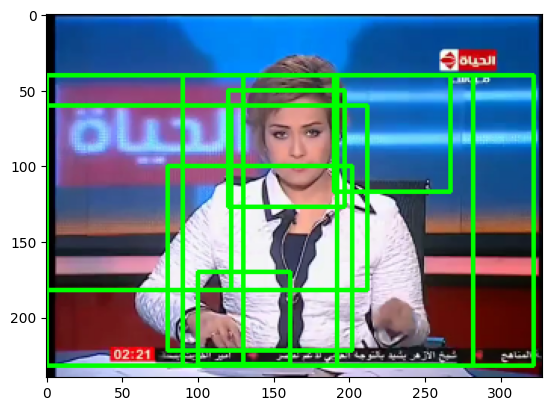

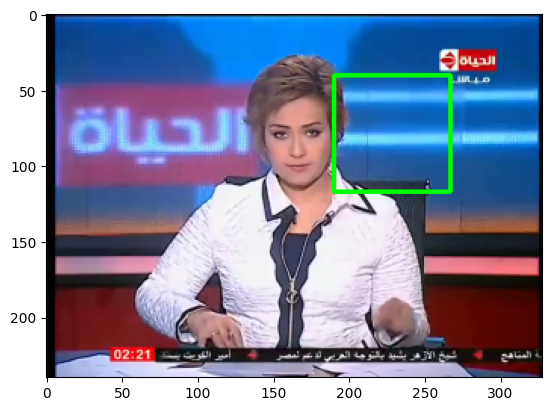

RGB
(720, 1280, 3)
(360, 640)
{'Getting Subwindows': 0.08162784576416016, 'Resizing Subwindows': 0.05381631851196289, 'Normalize': 1.1920928955078125e-05, 'Extracting Features': 0.06214284896850586, 'Classifying': 0.0449063777923584, 'total': 0.24250531196594238}


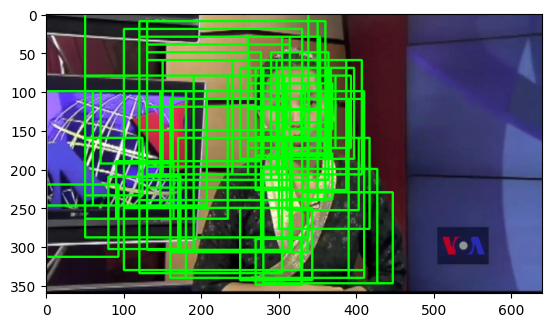

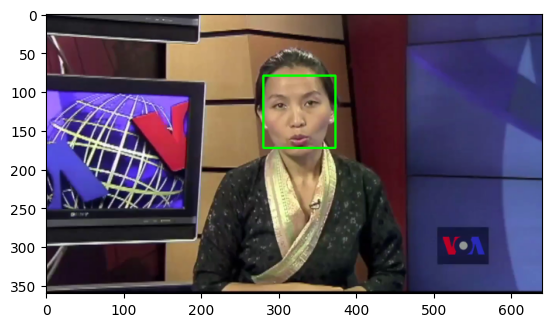

In [69]:
for i in show_images:
  # >>>> Read image <<<<
  img = Image.open(all_images_names[i])
  print(img.mode)
  img = np.array(img)
  print(img.shape)
  img = cv2.resize(img, (img.shape[1]//2, img.shape[0]//2))
  org_sh = img.shape
  if not rectangles_only:
    plt.imshow(img)
    plt.show()
  # get subwindows
  img2 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  print(img2.shape)

  # >>>> Normalize image <<<<
  # normalize image
  # img2 = (img2 - img2.mean()) / img2.std()
  # img2 = cv2.resize(img, resize_to)
  # print(img2.shape)

  # img2 = cv2.normalize(img2, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8U)
  # resize image
  # img2 = cv2.resize(img2, (570, 380))

  # show image
  if not rectangles_only:
    plt.imshow(img2, cmap='gray')
    plt.show()

  # +++++++++++++++++++++
  # find face
  # >>>> Find face <<<<
  face_coordinates, region_max_conf, max_conf , timing=\
                  faceDetector.find_face(img2)
  print(timing)
  # region_max_conf *= img.shape[0] / resize_to[0]
  # ++++++++++++++++++++
  # rectangles
  # >>>> Draw rectangles <<<<
  tmp_img = img.copy()
  # for face_coordinate in face_coordinates:
  for x1, y1, x2, y2 in face_coordinates:
      cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  # if not rectangles_only:
  plt.imshow(tmp_img)
  plt.show()

  # >>>> Draw rectangles with max confidence <<<<
  # amx confidence
  tmp_img = img.copy()
  x1, y1, x2, y2 = region_max_conf
  cv2.rectangle(tmp_img, (x1, y1), (x2, y2), (0, 255, 0), 2)
  plt.imshow(tmp_img)
  plt.show()

